In [1]:
import os
import gc
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.neighbors import (KNeighborsRegressor, 
                               NearestNeighbors)
from sklearn.model_selection import (cross_val_score,
                                     train_test_split,
                                     TimeSeriesSplit)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sys.path.append(r'C:\Users\Jameshuckle\Dropbox\My-Portfolio\AlgorithmicTrading\utils')
from data_util import (prep_fx_data, fit_data_for_knn)

pd.options.display.max_columns = 100
%matplotlib inline

C:\Users\Jameshuckle\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Get data

In [2]:
fx_files = [
             'EURUSD_1h_2003-2010.csv', 'EURUSD_1h_2010-2020.csv',
#              'USDJPY_1h_2003-2010.csv', 'USDJPY_1h_2010-2020.csv',
#              'NZDUSD_1h_2003-2020.csv',
#              'AUDUSD_1h_2003-2020.csv',
#              'USDCAD_1h_2003-2020.csv',
             ]

loaded_files = prep_fx_data(fx_files)

EURUSD_1h_2003-2010.csv
EURUSD_1h_2010-2020.csv


## Fit data for KNN

In [3]:
n_candles = [1,2,3,30]
(x_train, y_train, x_test, y_test, train_data_raw,
test_data_raw, knn_data) = fit_data_for_knn(loaded_files, window=5, n_candles=[1],
                                            norm_by_vol=False, resample=None, train_split=0.7)
knn_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,target_bars_1
0,0.000000,0.000000,0.000000,0.000000,-0.000276,-0.000027,-0.000703,-0.000570,-0.000053,-0.000053,-0.000722,-0.000641,-0.000071,0.001293,-0.000134,0.000793,-0.000232,0.000036,-0.001416,-0.001051,0.000107
1,-0.000276,-0.000027,-0.000703,-0.000570,-0.000053,-0.000053,-0.000722,-0.000641,-0.000071,0.001293,-0.000134,0.000793,-0.000232,0.000036,-0.001416,-0.001051,0.000009,0.000633,-0.000490,0.000107,0.000089
2,-0.000053,-0.000053,-0.000722,-0.000641,-0.000071,0.001293,-0.000134,0.000793,-0.000232,0.000036,-0.001416,-0.001051,0.000009,0.000633,-0.000490,0.000107,-0.000259,0.000241,-0.000918,0.000089,-0.000357
3,-0.000071,0.001293,-0.000134,0.000793,-0.000232,0.000036,-0.001416,-0.001051,0.000009,0.000633,-0.000490,0.000107,-0.000259,0.000241,-0.000918,0.000089,-0.000571,0.000125,-0.000740,-0.000357,0.000187
4,-0.000232,0.000036,-0.001416,-0.001051,0.000009,0.000633,-0.000490,0.000107,-0.000259,0.000241,-0.000918,0.000089,-0.000571,0.000125,-0.000740,-0.000357,0.000062,0.000892,-0.000276,0.000187,-0.000490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102434,-0.000027,0.000109,-0.000861,-0.000716,-0.000009,0.001034,-0.000054,0.000997,0.000018,0.000100,-0.000906,-0.000688,0.000000,0.000453,-0.000734,-0.000580,0.000009,0.000281,-0.000472,0.000027,0.000190
102435,-0.000009,0.001034,-0.000054,0.000997,0.000018,0.000100,-0.000906,-0.000688,0.000000,0.000453,-0.000734,-0.000580,0.000009,0.000281,-0.000472,0.000027,-0.000009,0.000245,-0.000272,0.000190,0.000073
102436,0.000018,0.000100,-0.000906,-0.000688,0.000000,0.000453,-0.000734,-0.000580,0.000009,0.000281,-0.000472,0.000027,-0.000009,0.000245,-0.000272,0.000190,0.000018,0.000227,-0.000082,0.000073,0.000154
102437,0.000000,0.000453,-0.000734,-0.000580,0.000009,0.000281,-0.000472,0.000027,-0.000009,0.000245,-0.000272,0.000190,0.000018,0.000227,-0.000082,0.000073,0.000000,0.000453,-0.000045,0.000154,-0.000172


## PCA

In [2]:
def find_n_idx_components(pca_obj, variance_thresh=0.99):
    explained_var = pca_obj.explained_variance_ratio_
    for idx in range(len(explained_var)):
        var_list = explained_var[:idx]
        if sum(var_list) >= variance_thresh:
#             print(idx + 1, 'pca features equals',sum(var_list),'explained variance')
#             print('this reduces dimensions down from', len(explained_var), 'to', idx + 1)
            return idx
        
# n_pc = find_n_idx_components(pca, variance_thresh=0.99)
# n_pc


def scale_data(X_train, X_test, df=False):
    scaler = StandardScaler()
    x_train_scale = scaler.fit_transform(X_train)
    mean, variance = scaler.mean_, scaler.var_
    x_test_scale = scaler.transform(X_test)
    if df:
        return pd.DataFrame(x_train_scale), pd.DataFrame(x_test_scale)
    return x_train_scale, x_test_scale


def pca_cv(x_train_cv, x_test_cv):  
    x_train_cv_scale, x_test_cv_scale = scale_data(x_train_cv, x_test_cv)
    pca = PCA()
    pcas = pca.fit_transform(x_train_cv_scale)
    n_pc_idx = find_n_idx_components(pca, variance_thresh=0.98)
    X_train_cv_pca = pd.DataFrame(pcas[:,:n_pc_idx])
    eigens = pca.components_[:n_pc_idx,:]
    X_test_cv_pca = x_test_cv_scale @ eigens.T
    
    return pd.DataFrame(X_train_cv_pca), pd.DataFrame(X_test_cv_pca)
    
# x_train_cv, x_test_cv =  X_train.iloc[0:100, :], X_train.iloc[100:110, :] 
# X_train_cv_pca, X_test_cv_pca = pca_cv(x_train_cv, x_test_cv)
# X_train_cv_pca

## GPU

In [3]:
import torch
print(torch.cuda.get_device_name(device=None), torch.cuda.is_available())

def knn_cuda(X_train, X_test, n_neighbors=5, gpu_step_size=500):
    '''
    Performs KNN using PyTorch and a GPU. It does so for a single "window" value.
    It creates a database with the training set and returns the the indecies of the
    n nearest neighbors for each of the test examples
    '''
    X_train_torch = torch.from_numpy(X_train.to_numpy()).cuda()
    X_test_torch = torch.from_numpy(X_test.to_numpy()).cuda()

    test_size = X_test.shape[0]
    start = 0
    n_neighbor_indices = []
    while start <= test_size:
        dist = torch.cdist(X_train_torch, X_test_torch[start:start + gpu_step_size])
        knn = dist.T.topk(n_neighbors, largest=False)
        n_neighbor_indices.append(knn.indices.cpu().numpy())
        start += gpu_step_size

    all_indices = np.vstack(n_neighbor_indices)

#     del X_train_torch
#     del X_test_torch
#     del dist
#     del knn
    torch.cuda.empty_cache() 

    return all_indices

# all_files = ['EURUSD_1h_2003-2010.csv']
# data = prep_fx_data(all_files)
# (x_train, y_train, x_test, y_test, train_data_raw,
# test_data_raw, knn_data) = fit_data_for_knn(data, window=5, n_candles=[1],
#                                             train_split=0.8)
# all_indices = knn_cuda(x_train, x_test, n_neighbors=5, gpu_step_size=500)
# all_indices

GeForce RTX 2070 True


In [4]:
import torch
print(torch.cuda.get_device_name(device=None), torch.cuda.is_available())

def knn_cuda_batch(X_train, X_test, max_neighbors=10, windows=[20], gpu_step_size=500,
                   close_only=False):
    '''
    Performs KNN using PyTorch and a GPU. It does so for multiple "window" values
    efficiently by using different slices of the input data. It can therefore calculate
    any window value <= the window value in the given dataset. 
    It creates a database with the training set and returns the indecies of the
    n nearest neighbors for each of the test examples
    '''

    bars = 1 if close_only else 4
    X_train_torch = torch.from_numpy(X_train.to_numpy()).cuda()
    X_test_torch = torch.from_numpy(X_test.to_numpy()).cuda()

    test_size = X_test.shape[0]
    window_indices = {}
    for w in windows:
        n_neighbor_indices = []
        start = 0
        while start <= test_size:
            # sorted smallest first
            dist = torch.cdist(X_train_torch[:, -w * bars:], 
                               X_test_torch[start:start + gpu_step_size, -w * bars:])
            knn = dist.T.topk(max_neighbors, largest=False, sorted=True)
            n_neighbor_indices.append(knn.indices.cpu().numpy())
            start += gpu_step_size
        all_indices = np.vstack(n_neighbor_indices)
        window_indices[w] = all_indices

#     del X_train_torch
#     del X_test_torch
#     del dist
#     del knn
    torch.cuda.empty_cache() 

    return window_indices   

# all_files = ['EURUSD_1h_2003-2010.csv']
# data = prep_fx_data(all_files)
# (x_train, y_train, x_test, y_test, train_data_raw,
# test_data_raw, knn_data) = fit_data_for_knn(data, window=5, n_candles=[1],
#                                            train_split=0.8)

# window_indices = knn_cuda_batch(x_train, x_test, max_neighbors=10, windows=[10,20,30],
#                                 gpu_step_size=500)
# window_indices

GeForce RTX 2070 True


## Test GPU model vs Sklearn output

In [5]:
def test_gpu_vs_sklearn():
    
    all_files = ['EURUSD_1h_2003-2010.csv']
    data = prep_fx_data(all_files)

    window = 5
    candles = 1
    n_neighbors = 5

    (x_train, y_train, x_test, y_test, train_data_raw,
    test_data_raw, knn_data) = fit_data_for_knn(data, window=window,
                                                 n_candles=[candles],
                                                 train_split=0.7)

    window_indices = knn_cuda_batch(x_train, x_test, max_neighbors=n_neighbors, windows=[window],
                                    gpu_step_size=500)
    cuda_indices = window_indices[window]

    model = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=-1, algorithm='brute')
    model.fit(x_train)
    sklearn_indices = model.kneighbors(x_test)[1]

    print('sklearn:',sklearn_indices)
    print('cuda:   ',cuda_indices)
    print('equal:', (sklearn_indices != cuda_indices).sum() == 0)

# test_gpu_vs_sklearn()

## CV functions

In [6]:
def TimeSeriesShift(n_splits, X_train):
    '''
    Yield tran and test CV indicies that shift across the dataset by a fixed size.
    Example
    Full data: [0,1,2,3,4,5]
    CV:
    [0,1][2]
    [1,2][3]
    [2,3][4]
    [3,4][5]
    '''
    split_size = int((len(X_train) / n_splits) + 1) # round up
    start = 0
    # gives wiggle room for non accurate split size
    while start < (len(X_train) - split_size):
        train_end = start + split_size
        test_end = min(start + split_size*2, len(X_train)) # stops indexes from getting too large
        x_train_split = np.array(range(start, train_end))
        x_test_split = np.array(range(train_end, test_end))
        yield (x_train_split, x_test_split)
        start += split_size

## Scoring

In [7]:
def trade_side(pred):
    if abs(pred) < min_pred_target_size_pct:
        return 0
    elif pred > 0:
        return 1
    elif pred <= 0:
        return -1

def trade_fees(profit):
    if profit == 0:
        return 0
    else:
        return profit - trade_fees_pct
    
def calc_romad(run_profit_series):
    last_value = run_profit_series.values[-1]
    if abs(last_value) < 0.0001:
        return 0
    draw_down = run_profit_series - run_profit_series.cummax()
    max_draw_down = draw_down.min()
    romad = (last_value / max_draw_down) * -1
    return romad

def sklearn_trading_scorer(estimator, X, y):
    pred = estimator.predict(X)
    target_col = list(y.columns)[0]
    # Caclulate profit
    pred = pd.Series(pred.flatten(), name='pred')
    i_data = pd.concat([pred, y.reset_index(drop=True)],axis=1)
    i_data['pred_dir'] = i_data['pred'].map(trade_side)
    i_data['profit'] = i_data[target_col] * i_data['pred_dir']
    #fees one basis point or 100th of 1 percent
    i_data['profit'] = i_data['profit'].map(trade_fees)
    i_data['run_profit'] = i_data['profit'].cumsum()
    romad = calc_romad(i_data['run_profit'])
    return romad


def cuda_trading_scorer(pred, y, output_candles, return_df=False):
    # Caclulate profit
    pred = pd.Series(pred, name='pred')
    i_data = pd.concat([pred, y.reset_index(drop=True)], axis=1) 
    i_data['pred_dir'] = i_data['pred'].map(trade_side)
    candle_romads = {}
    for c in output_candles:
        target_col = f'target_bars_{c}'
        i_data[f'profit_{target_col}'] = i_data[target_col] * i_data['pred_dir']
        #fees one basis point or 100th of 1 percent
        i_data[f'profit_{target_col}'] = i_data[f'profit_{target_col}'].map(trade_fees)
        i_data[f'run_profit_{target_col}'] = i_data[f'profit_{target_col}'].cumsum()
        romad = calc_romad(i_data[f'run_profit_{target_col}'])
        candle_romads[c] = romad
    if return_df == True:
        return candle_romads, i_data
    return candle_romads

## Ensemble scorers

In [8]:
def cuda_trading_scorer_vote_mean_med(pred_mean, pred_median, y, vote_type, target_col='target',
                             return_df=False):
    '''
    Take the average of the median and mean of each combination of hyperparameter’s predictions.
    Or, give a direction only when both mean and median are in the same direction (vote),
    otherwise don’t trade.
    '''
    # Caclulate profit
    pred_mean = pd.Series(pred_mean, name='pred_mean')
    pred_median = pd.Series(pred_median, name='pred_median')
    i_data = pd.concat([pred_mean, pred_median, y.reset_index(drop=True)], axis=1)
    
    def vote(row):
        if (row['pred_mean'] > 0) and (row['pred_median'] > 0):
            return (row['pred_mean'] + row['pred_median']) / 2
        elif (row['pred_mean'] < 0) and (row['pred_median'] < 0):
            return (row['pred_mean'] + row['pred_median']) / 2
        else:
            return 0  
        
    def vote_sum(row):
        return (row['pred_mean'] + row['pred_median']) / 2
    
    if vote_type == 'vote':
        scorer = vote 
    elif vote_type == 'vote_sum':
        scorer = vote_sum
    else:
        raise Exception('Vote_type not recognised')
        
    i_data['pred'] = i_data.apply(scorer, axis=1)
    i_data['pred_dir'] = i_data['pred'].map(ltrade_size)
    i_data['profit'] = i_data[target_col] * i_data['pred_dir']
    #fees one basis point or 100th of 1 percent
    i_data['profit'] = i_data['profit'].map(trade_fees)
    i_data['run_profit'] = i_data['profit'].cumsum()
    romad = calc_romad(i_data['run_profit'])
    if return_df == True:
        return romad, i_data
    return romad


def cuda_trading_scorer_vote(dict_of_results, y, output_candles, threshold=0.5, return_df=False):
    '''
    Combine the predictions of each combination of neighbor and window size and threshold them,
    for example, there needs to be x% of buys before considering it a buy,
    otherwise there is no trade.
    '''
    # Caclulate profit
    results = pd.DataFrame(dict_of_results).T
    results = results.applymap(trade_side)
    results['ratio'] = results[results == 1].sum(axis=1) / len(results.columns)
    
    def vote(x):
        if x >= threshold: return 1
        elif x <= (1 - threshold): return -1
        else: return 0
        
    results['pred_dir'] = results['ratio'].map(vote)
    i_data = pd.concat([results, y.reset_index(drop=True)], axis=1) 
    candle_romads = {}
    for c in output_candles:
        target_col = f'target_bars_{c}'
        i_data[f'profit_{target_col}'] = i_data[target_col] * i_data['pred_dir']
        #fees one basis point or 100th of 1 percent
        i_data[f'profit_{target_col}'] = i_data[f'profit_{target_col}'].map(trade_fees)
        i_data[f'run_profit_{target_col}'] = i_data[f'profit_{target_col}'].cumsum()
        i_data.dropna(inplace=True)
        romad = calc_romad(i_data[f'run_profit_{target_col}'])
        candle_romads[c] = romad
    if return_df == True:
        return candle_romads, i_data
    return candle_romads

## Main KNN functions

In [9]:
def time_series_cv_knn_batch(X_train, y_train, n_splits=3, n_neighbors=[10], windows=[20],
                             output_candles=list(range(1,31)), gpu_step_size=500,
                             ensemble=False, threshold=0.5, scale_only=False, pca=False,
                             shift_cv=False, close_only=False):
    '''
    ensemble = False, 'vote', 'mean', 'median'
    '''
    print('ensemble type:', ensemble)
    
    if shift_cv:
        print('shift cv')
        splits_gen = TimeSeriesShift(n_splits, X_train)
    else:
        print('split cv')
        splits_gen = TimeSeriesSplit(n_splits=n_splits).split(X_train)

        
    cv_score = {'mean':{},'median':{},'ensemble':[]}
    for train_idx, test_idx in splits_gen:
        x_train_cv, x_test_cv =  X_train.iloc[train_idx, :], X_train.iloc[test_idx, :] 
        
        if pca:
            x_train_cv, x_test_cv = pca_cv(x_train_cv, x_test_cv)
        elif scale_only:
            print('scaling')
            x_train_cv, x_test_cv = scale_data(x_train_cv, x_test_cv, df=True)
            
        window_indices = knn_cuda_batch(x_train_cv, x_test_cv, max_neighbors=max(n_neighbors),
                                        windows=windows,gpu_step_size=gpu_step_size,
                                        close_only=close_only)
        y_train_numpy = y_train.to_numpy()
        pred_ensemble = []
        for w in windows:
            for c_idx, c in enumerate(output_candles):
                cv_score['mean'].setdefault((w, c), {})
                cv_score['median'].setdefault((w, c), {})
                for n in n_neighbors:
                    '''
                    For a particular window size, output candle size and n neighbour
                    pred_mean gathers their indicies and returns the mean of their predicitons.
                    pred_mean is a list of mean predictions for each row.
                    '''
                    pred_mean = [np.mean(y_train_numpy[indices, c_idx]) 
                                 for indices in window_indices[w][:,:n]]
                    if ensemble:
                        #print('window:',w,'output_candles:',c,'neighbors:',n)
                        # used later to concatenate each set of predictions and form an ensemble
                        pred_ensemble.append(pred_mean)
                    else:
                        pred_median = [np.median(y_train_numpy[indices, c_idx]) 
                                       for indices in window_indices[w][:,:n]]
                        score_mean = cuda_trading_scorer(pred_mean, y_train.iloc[test_idx, :],
                                                         output_candles=[c])
                        score_median = cuda_trading_scorer(pred_median, y_train.iloc[test_idx, :],
                                                           output_candles=[c])
                        cv_score['mean'][(w, c)].setdefault(n, []).append(score_mean[c])
                        cv_score['median'][(w, c)].setdefault(n, []).append(score_median[c])
                        #print('window:',w,'output_candles:',c,'neighbors:',n, 'score med:',
                        #      score_median,'score mean:',score_mean)

        
        if ensemble:
            if ensemble == 'vote':
                score_mean = cuda_trading_scorer_vote(pred_ensemble, y_train.iloc[test_idx, :],
                             output_candles=output_candles, threshold=threshold)
            else:
                results_scorer = np.mean if ensemble == 'mean' else np.median
                score_mean = cuda_trading_scorer(results_scorer(pred_ensemble, axis=0),
                                                 y_train.iloc[test_idx, :],
                                                 output_candles=output_candles)
            cv_score['ensemble'].append(score_mean)
                                         
        print('CV done...')
    
    if ensemble:
        ensemble_data = {}
        for cv in cv_score['ensemble']:
            for candle, score in cv.items():
                ensemble_data.setdefault(candle,[]).append(score)
        return {'ensemble':ensemble_data}
    else:
        return {'mean':cv_score['mean'], 'median':cv_score['median']}

 
def time_series_cv_knn_vote_mean_med(X_train, y_train, n_splits=3, n_neighbors=10, gpu_step_size=500,
                            vote_type='vote_sum', scale_only=False, pca=False):

    tss = TimeSeriesSplit(n_splits=n_splits)
    splits_gen = tss.split(X_train)

    cv_score = []
    for train_idx, test_idx in splits_gen:
        x_train_cv, x_test_cv =  X_train.iloc[train_idx, :], X_train.iloc[test_idx, :] 
        
        if pca:
            x_train_cv, x_test_cv = pca_cv(x_train_cv, x_test_cv)
        elif scale_only:
            print('scaling')
            x_train_cv, x_test_cv = scale_data(x_train_cv, x_test_cv, df=True)
            
        all_indices = knn_cuda(x_train_cv, x_test_cv, n_neighbors=n_neighbors,
                               gpu_step_size=gpu_step_size)
        y_train_numpy = y_train.to_numpy()
        pred_mean = [np.mean(y_train_numpy[indices]) for indices in all_indices]
        pred_median = [np.median(y_train_numpy[indices]) for indices in all_indices]
        score = cuda_trading_scorer_vote_mean_med(pred_mean, pred_median, y_train.iloc[test_idx, :],
                                         vote_type=vote_type)
        cv_score.append(score)
    
    return np.array(cv_score)

## Test GPU model vs Sklearn output

In [10]:
def test_gpu_vs_sklearn_time_series():
   
    all_files = ['EURUSD_1h_2003-2010.csv']
    data = prep_fx_data(all_files)
    
    n_splits = 5
    window = 5
    candles = 2
    n_neighbors = 5
 
    global trade_fees_pct
    global min_pred_target_size_pct
    trade_fees_pct = 0.0001
    min_pred_target_size_pct = 0.0004

    (x_train, y_train, x_test, y_test, train_data_raw,
    test_data_raw, knn_data) = fit_data_for_knn(data, window=window,
                                                n_candles=[candles],
                                                train_split=0.7)

    #### cuda #####  
    cv_score_cuda = time_series_cv_knn_batch(x_train, y_train, n_splits=n_splits,
                                             n_neighbors=[n_neighbors], windows=[window],
                                             output_candles=[candles], gpu_step_size=500,
                                             shift_cv=False, ensemble=False)
    cv_score_cuda = cv_score_cuda['mean'][(window, candles)][n_neighbors]

    ##### sklearn #####
    model = KNeighborsRegressor(n_neighbors=n_neighbors, n_jobs=-1)
    n_splits = n_splits
    tss = TimeSeriesSplit(n_splits=n_splits)
    cv_score = cross_val_score(model, x_train, y_train, cv=tss, scoring=sklearn_trading_scorer)

    print('sklearn:',list(cv_score))
    print('cuda:   ',cv_score_cuda)
    print('equal:', list(cv_score) == cv_score_cuda)

# test_gpu_vs_sklearn_time_series()

In [11]:
def plot_heatmap_table(table, title, xaxis='neighbors', yaxis='window - n_candle',
                       colorbar='romad', figsize=(10,15)):
    plt.figure(figsize = figsize)
    sns.heatmap(table.round(1), annot=True, cbar_kws={'label': colorbar})
    plt.title(title, fontsize=15)
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()

## Visualization of knn bars

In [13]:
def plot_bars(data, window):
    numpy_bars = data.to_numpy().reshape(-1,4)
    times = pd.date_range(start=datetime.now(), periods=window)
    bars = pd.DataFrame(numpy_bars, columns=['Open','High','Low','Close'])
    bars['time'] = times
    bars = bars[['time','Open','High','Low','Close']]
    bars.set_index('time',drop=True, inplace=True)
    mpf.plot(bars, type='candle', figscale=0.9)
    
def plot_n_predictions(X_test, y_test, X_train, y_train, window, predictions, prediction_idx,
                       n_charts_to_plot):
    print('----- main ------')
    print(y_test.iloc[prediction_idx])
    plot_bars(X_test.iloc[prediction_idx], window)
    print('----- prediction values ------')
    preds = y_train.iloc[predictions[prediction_idx]]
    print(preds.describe())
    print('median:',preds.median().values)
    print()
    print('----- plotting of neighbors -----')
    for b in predictions[prediction_idx][:n_charts_to_plot]:
        bars = X_train.iloc[b]
        target = y_train.iloc[b]
        print(target)
        plot_bars(bars, window)

In [14]:
instrument = ['EURUSD_1h_2003-2010.csv', 'EURUSD_1h_2010-2020.csv']
data = prep_fx_data(instrument)

EURUSD_1h_2003-2010.csv
EURUSD_1h_2010-2020.csv


In [15]:
n_neighbors = 10
window = 10
n_candles = [1] # how many canldes to predict

(x_train, y_train, x_test, y_test, train_data_raw,
test_data_raw, knn_data) = fit_data_for_knn(data, window=window,
                                            n_candles=n_candles,
                                            percentage_diff=False,
                                            train_split=0.7)

knn = NearestNeighbors(n_neighbors=n_neighbors)
knn.fit(x_train, y_train)
dist, neighbors = knn.kneighbors(x_test)

----- main ------
target_bars_1   -0.000353
Name: 25, dtype: float64


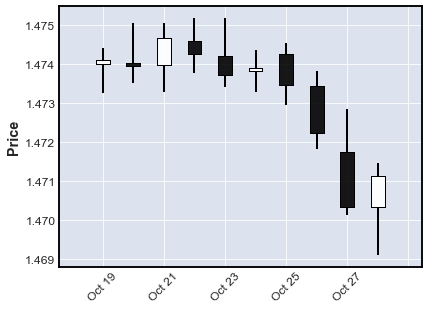

----- prediction values ------
       target_bars_1
count      10.000000
mean       -0.000466
std         0.001464
min        -0.003274
25%        -0.000153
50%         0.000020
75%         0.000377
max         0.000754
median: [2.03917476e-05]

----- plotting of neighbors -----
target_bars_1    0.00051
Name: 29152, dtype: float64


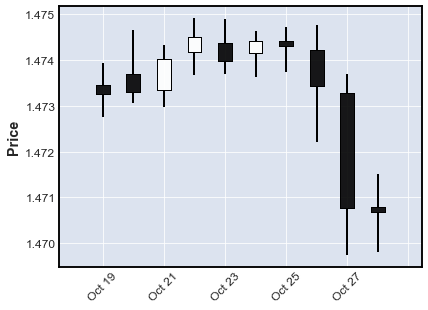

target_bars_1   -0.000183
Name: 29153, dtype: float64


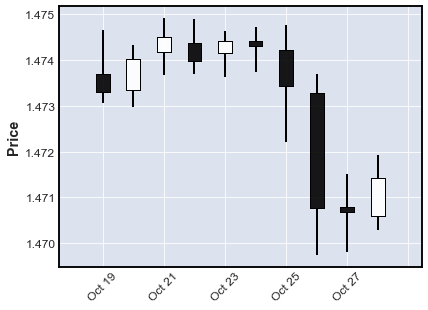

target_bars_1    0.000224
Name: 29154, dtype: float64


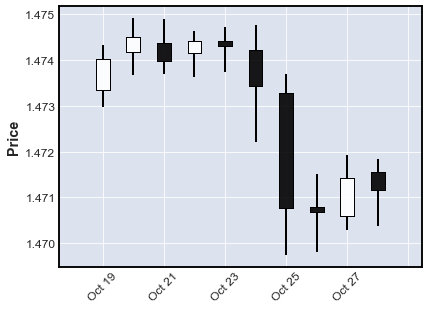

target_bars_1   -0.000061
Name: 29151, dtype: float64


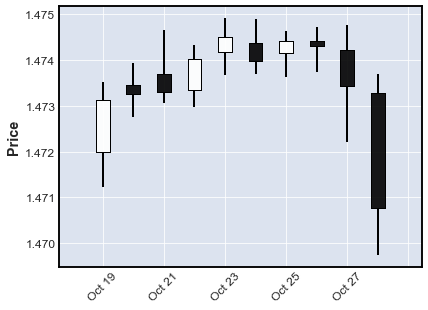

target_bars_1   -0.000054
Name: 28721, dtype: float64


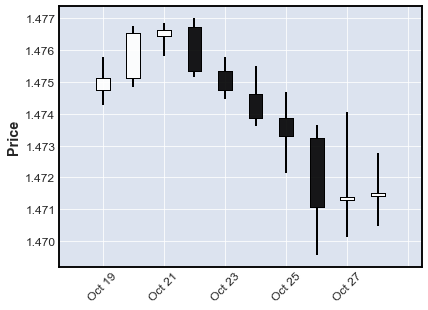

In [16]:
import mplfinance as mpf
test_row_idx_to_plot = 25
n_charts_to_plot = 5
plot_n_predictions(x_test, y_test, x_train, y_train, window, neighbors, 
                   prediction_idx=test_row_idx_to_plot, n_charts_to_plot=n_charts_to_plot)

### Plain and ensemble cross fold validation model

In [17]:
all_files = [
             'EURUSD_1h_2003-2010.csv', 'EURUSD_1h_2010-2020.csv',
             'USDJPY_1h_2003-2010.csv', 'USDJPY_1h_2010-2020.csv',
             'NZDUSD_1h_2003-2020.csv',
             'AUDUSD_1h_2003-2020.csv',
             'USDCAD_1h_2003-2020.csv',
            ]
data = prep_fx_data(all_files)

EURUSD_1h_2003-2010.csv
EURUSD_1h_2010-2020.csv
USDJPY_1h_2003-2010.csv
USDJPY_1h_2010-2020.csv
NZDUSD_1h_2003-2020.csv
AUDUSD_1h_2003-2020.csv
USDCAD_1h_2003-2020.csv


In [284]:
gpu_step_size = 300
n_splits = 5

windows = [10,30,50,100]
output_candles = [5,10,20,50,100,200]
n_neighbors = [5,10,25,50,100,200,500,1000]

# windows = [50]
# output_candles = [5]
# n_neighbors = [500]

global trade_fees_pct
global min_pred_target_size_pct
trade_fees_pct = 0.0001 #1/15 #0.0001
min_pred_target_size_pct = 0.0004 #(1/15)*4 #0.0006
resample = None #None #'1D'
norm_by_vol = False
close_only = False

ensemble = False #False, 'vote', 'median', 'mean'
threshold = 0.5 # only used if ensemble == 'vote'
### ^ shoud add threshold var to scorer func to iterate through it and produce tables,
### rather than waste time putting singles

scale_only = True
pca = False
shift_cv = False

start = datetime.now()

(x_train, y_train, x_test, y_test, train_data_raw,
test_data_raw, knn_data) = fit_data_for_knn(data, window=max(windows),
                                            n_candles=output_candles,
                                            close_only=close_only,
                                            norm_by_vol=norm_by_vol,
                                            resample=resample,
                                            train_split=0.7)

cv_score_cuda = time_series_cv_knn_batch(x_train, y_train, n_splits=n_splits, n_neighbors=n_neighbors,
                                        windows=windows, output_candles=output_candles,
                                        gpu_step_size=gpu_step_size,
                                        ensemble=ensemble, threshold=threshold,
                                        shift_cv=shift_cv, close_only=close_only,
                                        scale_only=scale_only, pca=pca)

inspect_results = pd.DataFrame(cv_score_cuda)
inspect_results.to_pickle(f'inspect_results_backup.pkl')
#del knn_data, x_train, y_train #x_train, x_test, y_train, y_test
        
end = datetime.now()
print('it took:',end-start)
all_results = inspect_results.copy()
inspect_results


ensemble type: False
split cv
scaling


C:\Users\Jameshuckle\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


CV done...
scaling
CV done...
scaling
CV done...
scaling


C:\Users\Jameshuckle\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


CV done...
scaling


C:\Users\Jameshuckle\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


CV done...
it took: 1:03:36.624003


mean  \
10  5    {5: [-0.9972921236155882, -0.9759452151463244,...   
    10   {5: [-0.8736672250235181, -0.6947642210237603,...   
    20   {5: [-0.9653562333559002, 0.9970110657146039, ...   
    50   {5: [-0.7217392668724253, 0.023859713462379174...   
    100  {5: [-0.9273954004303011, -0.12098081356059848...   
    200  {5: [-0.8091699306255716, -0.19349493929722564...   
30  5    {5: [-0.9708165067364971, -0.9721455157672364,...   
    10   {5: [-0.9238832751513892, -0.9670929233776225,...   
    20   {5: [-0.9350196935396722, -0.8985317163321414,...   
    50   {5: [-0.7957848117568079, -0.9732643889426951,...   
    100  {5: [-0.7672887501539454, -0.621398545291515, ...   
    200  {5: [-0.14273684131067954, -0.3992277023478491...   
50  5    {5: [-0.97434069006109, -0.9744481425080814, -...   
    10   {5: [-0.9719850072948011, -0.9276217799138271,...   
    20   {5: [-0.9588187628709443, -0.9500451966996433,...   
    50   {5: [-0.18804178457499332, -0.3906319557218142...   
    100  {5: [-0.5990840283069854, 0.04769774158727175,...   
    200  {5: [-0.5075654685789105, -0.6075837858091631,...   
100 5    {5: [-0.9798562703282818, -0.9858924739719849,...   
    10   {5: [-0.9369090540031777, -0.7575688587369603,...   
    20   {5: [-0.9446857723148034, -0.48472246735854585...   
    50   {5: [-0.9713508549868827, -0.16853191045434535...   
    100  {5: [-0.3788399688783408, 0.4907281041342024, ...   
    200  {5: [-0.7511044092635323, -0.7155115004825305,...   

                                                    median  
10  5    {5: [-0.9864588506438824, -0.9858998364643013,...  
    10   {5: [-0.9631852540431795, -0.7616003214905707,...  
    20   {5: [-0.9086759618812628, -0.32502965426095715...  
    50   {5: [-0.4602886480141505, 1.3360430958300706, ...  
    100  {5: [-0.8481853657715303, -0.2055653216667062,...  
    200  {5: [-0.6934446209013895, -0.18352908856282651...  
30  5    {5: [-0.9407562154961573, -0.993156641080968, ...  
    10   {5: [-0.9265681742941423, -0.9892386555110538,...  
    20   {5: [-0.8836512892295828, -0.9840357966435147,...  
    50   {5: [-0.8999613472899258, -0.7400820912642647,...  
    100  {5: [-0.6848661700965734, -0.7476572965423521,...  
    200  {5: [-0.44061139105148434, -0.4297709994336298...  
50  5    {5: [-0.9639283542949982, -0.9932919649812125,...  
    10   {5: [-0.9470882692290298, -0.9527697002520171,...  
    20   {5: [-0.9497247699456376, -0.9628711343040278,...  
    50   {5: [-0.35296325457819494, -0.2199932960533932...  
    100  {5: [-0.5335878206423356, 0.1837543195181456, ...  
    200  {5: [-0.517676460598547, -0.8046913254442268, ...  
100 5    {5: [-0.9804508621728206, -0.988816071696114, ...  
    10   {5: [-0.9355427123877891, -0.9748174845243257,...  
    20   {5: [-0.9823288847466092, -0.6745814838862184,...  
    50   {5: [-0.9820168478201872, -0.3498588847200557,...  
    100  {5: [0.35861397660565286, 0.06505273537536346,...  
    200  {5: [-0.6892139653224404, -0.6215888855950938,...

### Mean / median ensemble cross validation model

In [278]:
# gpu_step_size = 200

# global trade_fees_pct
# global min_pred_target_size_pct
# trade_fees_pct = 0.0001
# min_pred_target_size_pct = 0.0004

# start = datetime.now()
# all_results = {'vote':{}}
# for window in [40]:
#     for n_candles in [5]:
#     (x_train, y_train, x_test, y_test, train_data_raw,
#     test_data_raw, knn_data) = fit_data_for_knn(data, window=max(windows),
#                                                 n_candles=output_candles,
#                                                 close_only=close_only,
#                                                 train_split=0.7)
        
#         results = {'vote':{}}
#         for n in [500]:
#             cv_score_cuda = time_series_cv_knn_vote_mean_med(X_train, y_train, n_splits=10,
#                                                     n_neighbors=n,
#                                                     gpu_step_size=gpu_step_size, 
#                                                     vote_type='vote_sum', scale_only=False,
#                                                     pca=False)

#             results['vote'][n] = cv_score_cuda
#             print('window',window,'n_candles',n_candles,'nn',n)
#             print('cv_score_vote',cv_score_cuda)
#             print('----------')

#         all_results['vote'][(window, n_candles)] = results['vote']
#         print('results', results)
#         inspect_results = pd.DataFrame(all_results)
#         inspect_results.to_pickle(f'inspect_results_backup.pkl')
#         del knn_data, X_train, y_train #X_train, X_test, y_train, y_test
        
# end = datetime.now()
# print('it took:',end-start)
# all_results

### Results

In [285]:
inspect_results = pd.DataFrame(all_results)
now = str(datetime.now().date())
inspect_results.to_pickle(f'inspect_results_{now}.pkl')
new_data = pd.read_pickle(f'inspect_results_{now}.pkl')
means = pd.DataFrame(new_data['mean'].to_dict())
medians = pd.DataFrame(new_data['median'].to_dict())
medians

10   \
                                                    5     
5     [-0.9864588506438824, -0.9858998364643013, -0....   
10    [-0.9872336539201394, -0.9817679438902825, -0....   
25    [-0.8800522732632503, -0.8701525173765821, -0....   
50    [-0.668597289194923, -0.8896109121902778, -0.4...   
100   [0.21397220224079988, -0.5604876299987066, -0....   
200   [-0.26843185981989753, -0.1959264345381679, 1....   
500   [-0.35118530883204485, -0.8392294158139624, 2....   
1000  [-inf, 0.07640955222675164, -0.518903629970106...   

                                                         \
                                                    10    
5     [-0.9631852540431795, -0.7616003214905707, -0....   
10    [-0.9111387516216691, -0.6360857589530087, -0....   
25    [-0.8923469266066044, -0.5862366220063304, -0....   
50    [-0.847714884138011, -0.6261867619244564, -0.9...   
100   [0.03348949387361157, -0.18023042954838295, -0...   
200   [0.8386108289979851, -0.774222975407514, -0.59...   
500   [0.8327449019022647, -0.7128300566663561, 0.28...   
1000  [-0.4904204273070518, 0.3876660878122053, 2.34...   

                                                         \
                                                    20    
5     [-0.9086759618812628, -0.32502965426095715, -0...   
10    [-0.8833701342248744, 0.6220262318198153, -0.7...   
25    [-0.9110717634350002, 0.13284040498147776, -0....   
50    [-0.8657225322857105, 0.6009679281277596, 0.29...   
100   [-0.7345978338733702, 0.44447127860282115, 0.9...   
200   [-0.7732978251869433, 0.005318484195960662, 1....   
500   [-0.43079651686126624, 0.2585093012993296, 2.4...   
1000  [-0.579222262728352, -0.04857957086246439, 3.8...   

                                                         \
                                                    50    
5     [-0.4602886480141505, 1.3360430958300706, -0.6...   
10    [-0.4248818208360375, 0.8709030632498256, -0.4...   
25    [-0.5394274733549858, 0.6379067079342536, 0.09...   
50    [-0.5954665040741292, 0.48606255675908083, 0.1...   
100   [-0.6339557493232439, 0.04082960151771552, 0.6...   
200   [-0.5509301461536597, -0.10656348838214313, 1....   
500   [-0.41565523108591973, -0.054236140923591906, ...   
1000  [-0.442871318408165, -0.013349137433415254, 0....   

                                                         \
                                                    100   
5     [-0.8481853657715303, -0.2055653216667062, -0....   
10    [-0.8259111432443824, 0.17538349327850167, -0....   
25    [-0.8669386016719708, 0.0652084959807018, 0.42...   
50    [-0.8572366484727827, 0.1895487814913887, 0.76...   
100   [-0.8385625649989819, 0.07532961124050722, 1.2...   
200   [-0.7802925625363052, 0.08686147307566049, 1.0...   
500   [-0.8237421564840866, 0.08441619879296429, 1.1...   
1000  [-0.82119099102169, 0.036454982873128046, 0.87...   

                                                         \
                                                    200   
5     [-0.6934446209013895, -0.18352908856282651, -0...   
10    [-0.7739665195454675, -0.10641054578578919, -0...   
25    [-0.5620327192025149, 0.01298810032721083, -0....   
50    [-0.6195519603463445, 0.002882430157250547, 0....   
100   [-0.6235427128911764, 0.1404544026213802, 0.54...   
200   [-0.5644836792009019, 0.09060620293944183, 0.7...   
500   [-0.4178498160713865, 0.14668642509107896, 1.0...   
1000  [-0.5280226720966873, 0.2342961163467698, 1.28...   

                                                    30   \
                                                    5     
5     [-0.9407562154961573, -0.993156641080968, -0.8...   
10    [-0.921661632836362, -0.9961073634439032, -0.7...   
25    [-0.9290846387048037, -0.8487284627118603, -0....   
50    [-0.8804476268067355, 0.148222022009223, -0.11...   
100   [-0.8811677536921226, 0.12443409735214624, 0.7...   
200   [-0.3580843403242362, -0.06731377234935183, 1....   
500   [0.03558807018232781, -0.001

In [286]:
if ensemble:
    bars = 2
    cvs = [round(d,2) for d in new_data['ensemble'][bars]]
    print(cvs)
    print(sum(cvs))
    pd.Series(new_data['ensemble'][bars]).plot(lw='4',title=f'ensemble {bars} bars')

In [288]:
scorers = ['mean'] # ['vote'] ['mean','median'] ['ensemble']
tables = {s:{} for s in scorers}
for scorer in scorers:
    if scorer == 'ensemble':
        the_data = new_data.copy()
    else:
        the_data = pd.DataFrame(new_data[scorer].to_dict())
    the_data = the_data.applymap(lambda x: np.array(x))
    tables[scorer]['learning'] = the_data.applymap(lambda x: (int(x[int(n_splits*0.25)] 
                                                                 < x[n_splits // 2] 
                                                                 < x[int(n_splits*0.75)])))
    tables[scorer]['sum'] = the_data.applymap(lambda x: np.sum(x))
    tables[scorer]['inverse_std'] = the_data.applymap(lambda x: 1 / np.std(x))
    tables[scorer]['median'] = the_data.applymap(lambda x: np.median(x))
    tables[scorer]['min'] = the_data.applymap(lambda x: np.min(x))
    tables[scorer]['last'] = the_data.applymap(lambda x: x[-1])
    weight_arr = list(range(n_splits))
    tables[scorer]['weighted'] = the_data.applymap(lambda x: (((np.array(x) * weight_arr) 
                                                              / sum(weight_arr)).sum()))

C:\Users\Jameshuckle\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply


----------------------


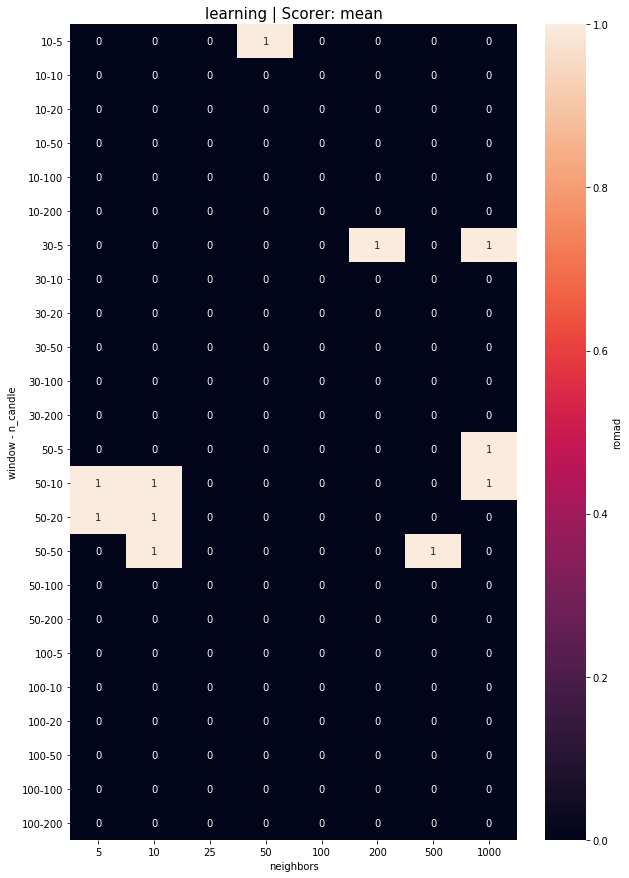

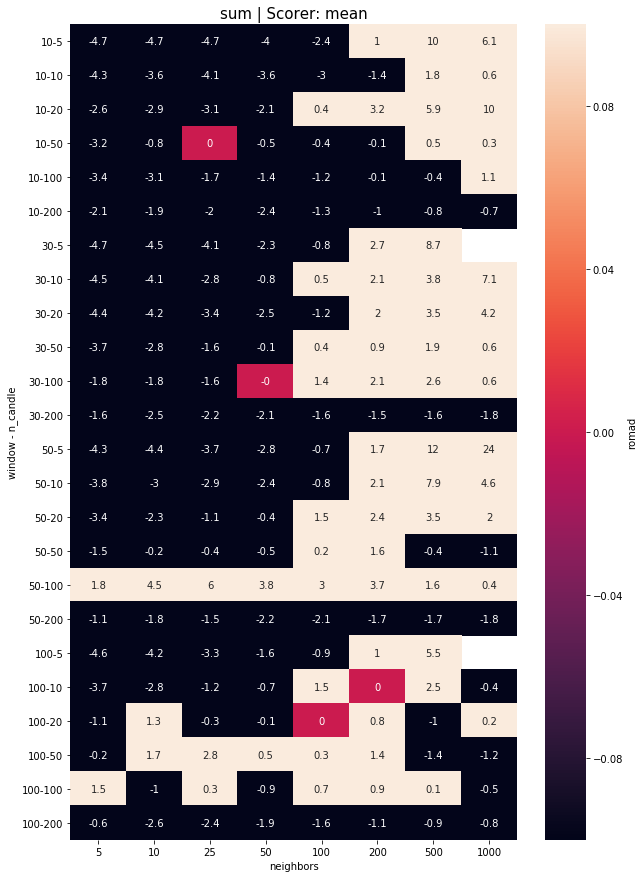

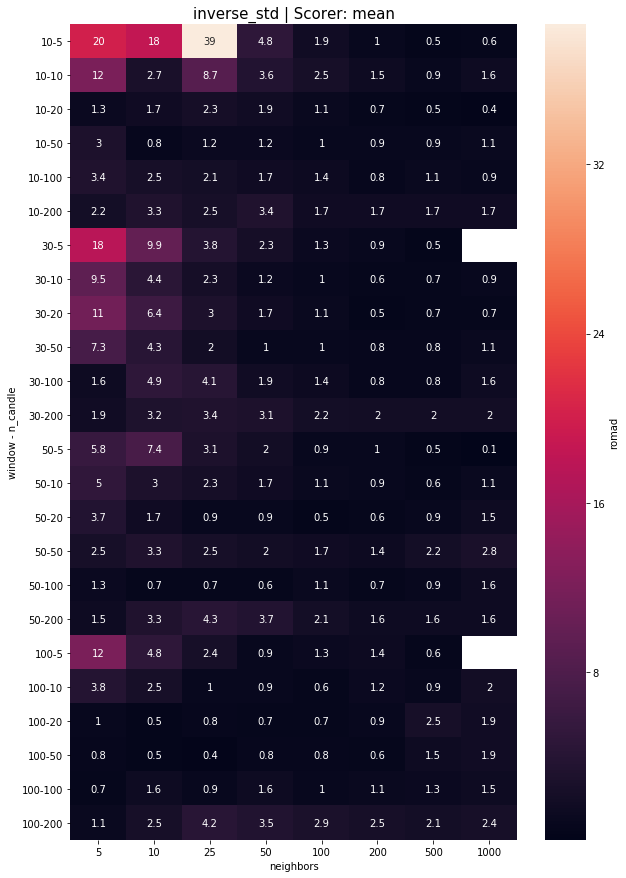

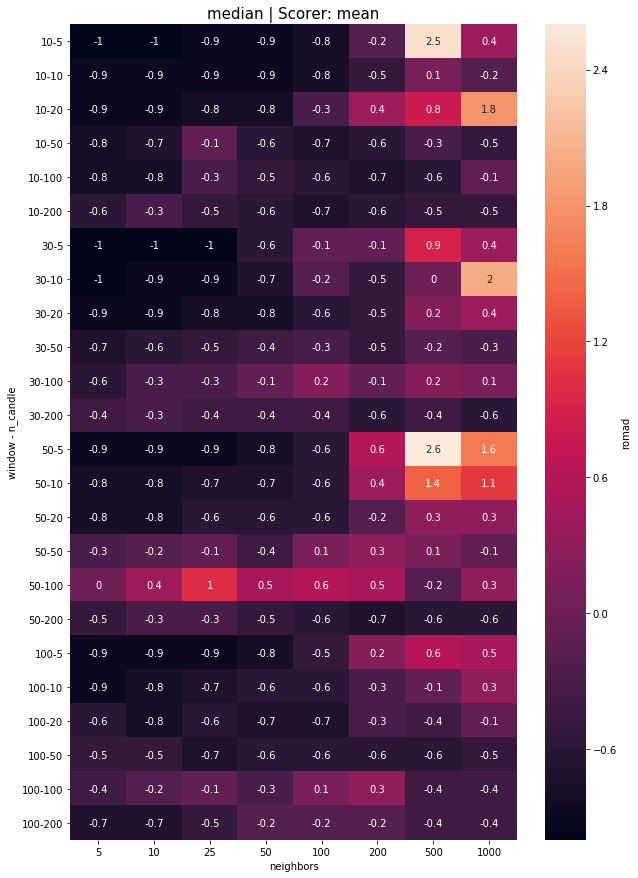

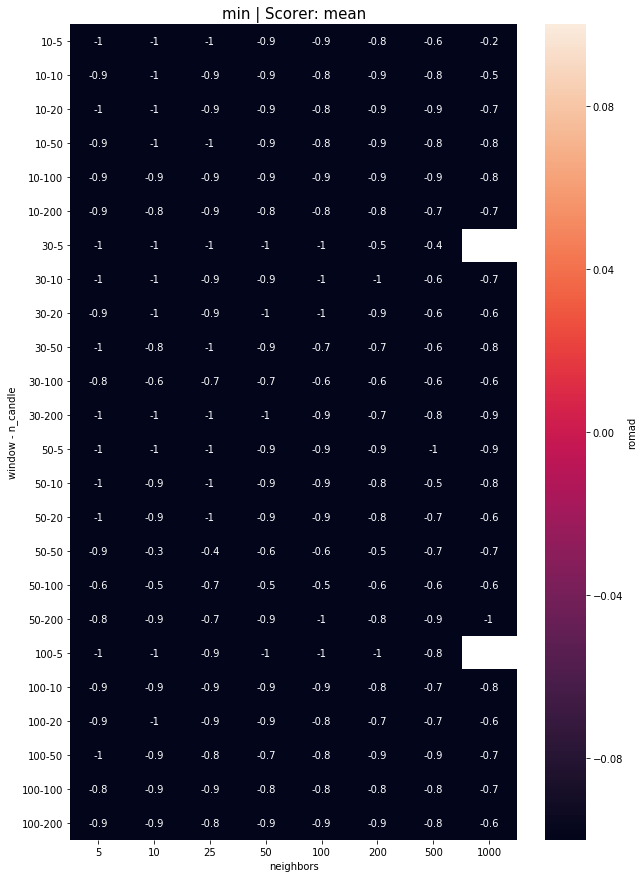

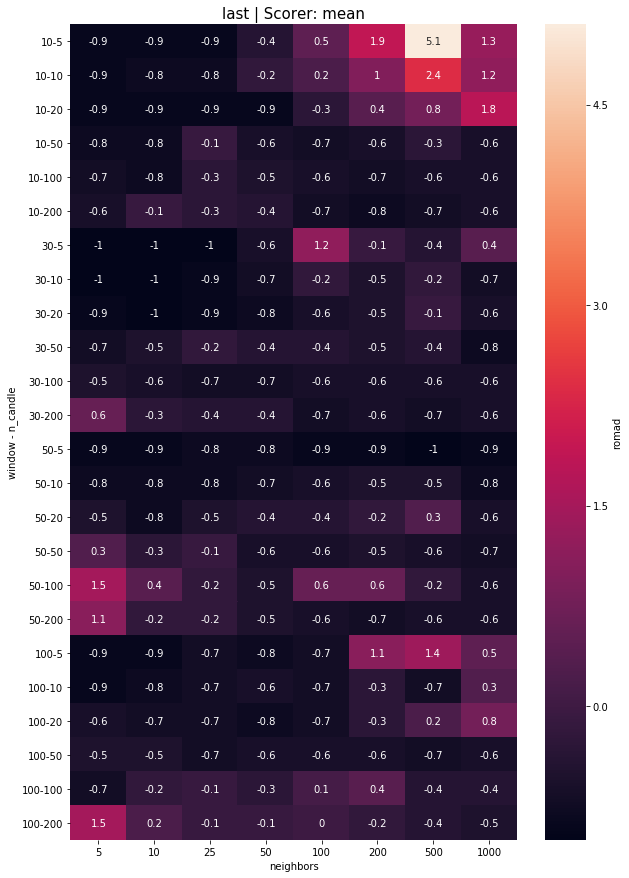

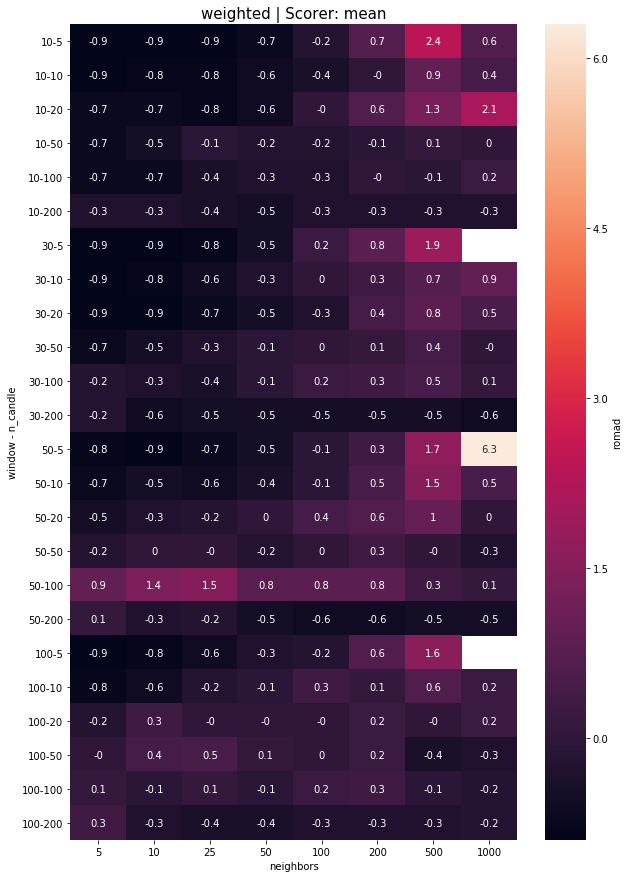

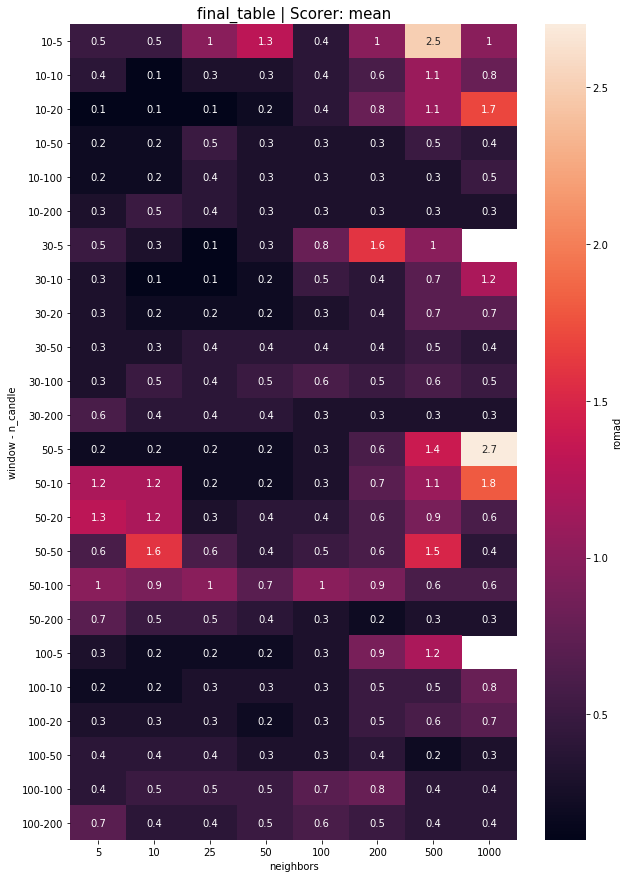

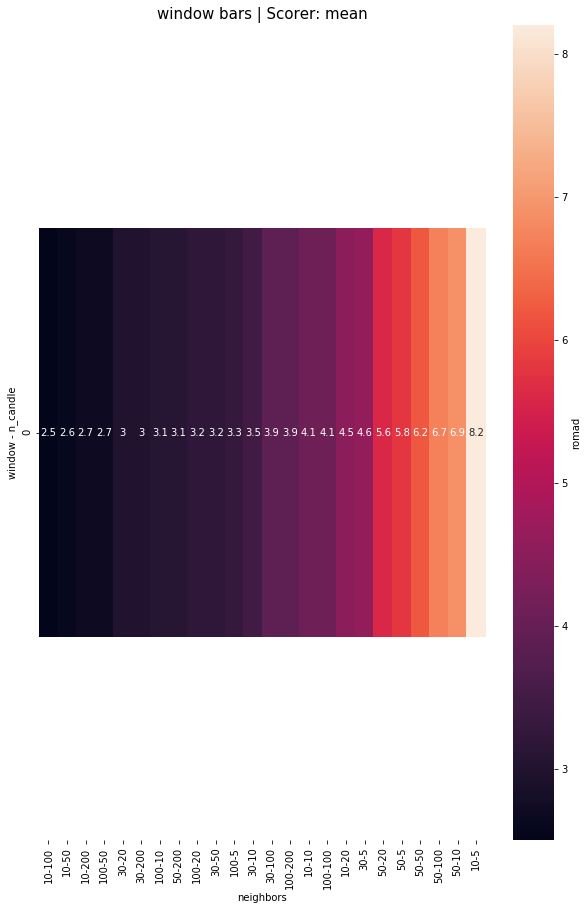

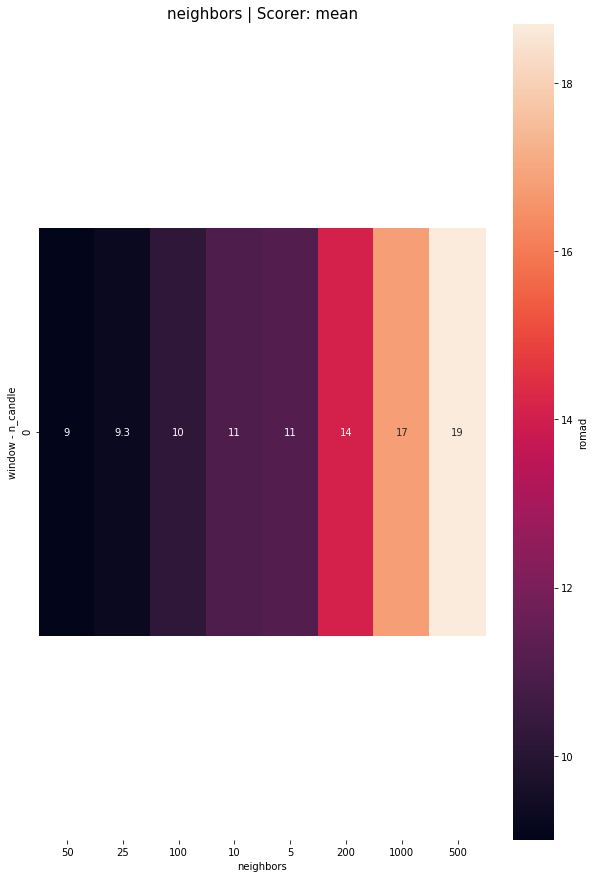

---------------


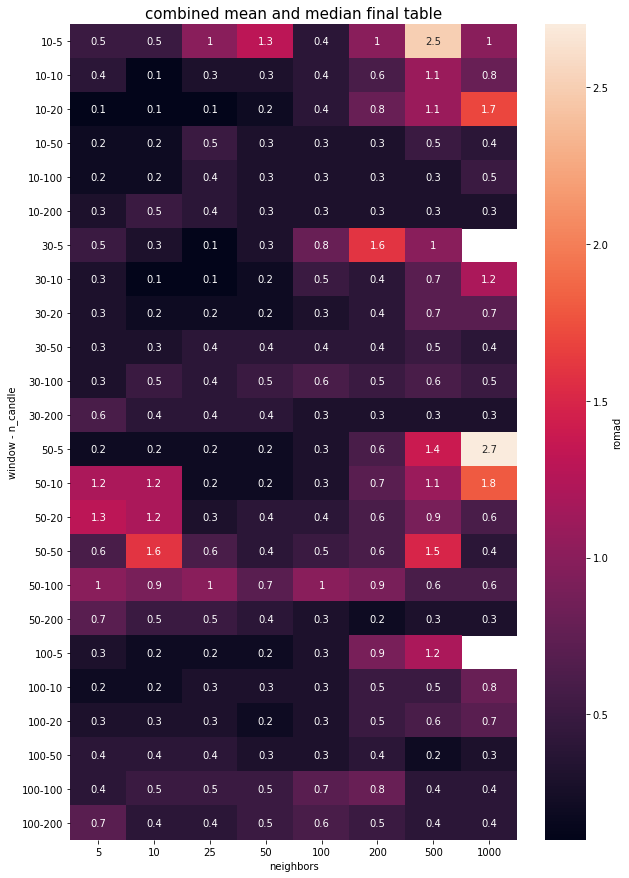

---------------


KeyError: 'median'

In [289]:
comparison = {}
final_tables = []
for scorer in scorers: 
    print('----------------------')
    table_comparison = {}
    norm_tables = []
    for name, table in tables[scorer].items():
        plot_heatmap_table(table.T, title=f'{name} | Scorer: {scorer}')
        best_scores = sorted(table.to_numpy().flatten(), reverse=True)[:10]
        table_comparison[f'{name} | sum'] = table.sum().sum()
        table_comparison[f'{name} | median'] = table.median().median()
        table_comparison[f'{name} | best_sum'] = sum(best_scores)
        table_comparison[f'{name} | best_median'] = np.median(best_scores)
        minimum = table.min().min()
        maxuimum = table.max().max()
        normalized = (table - minimum) / (maxuimum - minimum)
        norm_tables.append(normalized)
    comparison[scorer] = table_comparison
    f_table = sum([f for f in norm_tables if f.sum().sum() > 0])
    final_tables.append(f_table)
    plot_heatmap_table(f_table.T, f'final_table | Scorer: {scorer}')
    plot_heatmap_table(pd.DataFrame(f_table.sum(axis=0).sort_values()).T,
                                    f'window bars | Scorer: {scorer}')
    plot_heatmap_table(pd.DataFrame(f_table.sum(axis=1).sort_values()).T,
                                    f'neighbors | Scorer: {scorer}')
    
print('---------------')
plot_heatmap_table(sum(final_tables).T, 'combined mean and median final table')
#plot_heatmap_table(f_tables[0] - f_tables[1], 'combined mean and median final table diff')
print('---------------')
final_comp = pd.DataFrame(comparison).round(1)

def winner(row):
    diff = row['mean'] - row['median']
    if diff > 0: return 'mean'
    elif diff < 0: return 'median'
    else: return '-----'
final_comp['winner'] = final_comp.apply(winner, axis=1)
final_comp

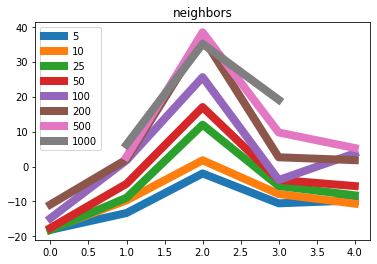

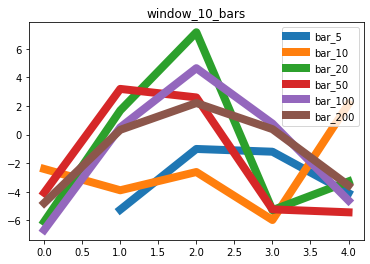

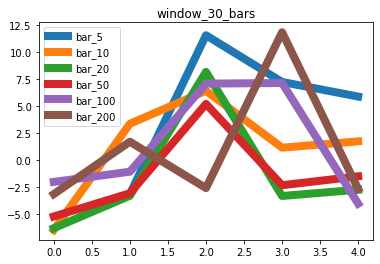

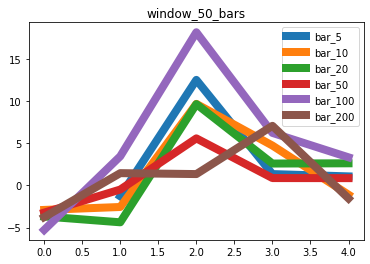

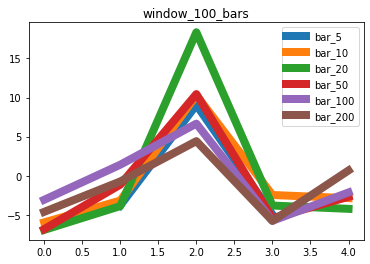

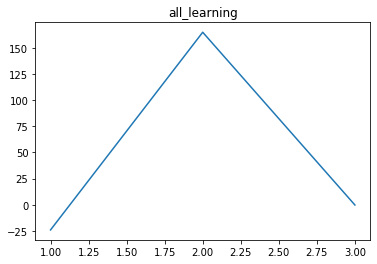

[        -inf -24.02834497 164.84107125  -0.20584313         -inf]


In [291]:
the_data = pd.DataFrame(new_data['median'].to_dict())
the_data = the_data.applymap(lambda x: np.array(x))
neighbors = the_data.sum(axis=1)
for n, stats in neighbors.items():
    plt.plot(stats, label=n, lw=8)
plt.legend()
plt.title('neighbors')
plt.show()

window_bars = the_data.sum(axis=0)
windows = sorted(list(set([w[0] for w in window_bars.index.values])))
for window in windows:
    for n, stats in window_bars[window].items():
        plt.plot(stats, label=f'bar_{n}', lw=8)
    plt.legend()
    plt.title(f'window_{window}_bars')
    plt.show()

all_learning = the_data.sum().sum()
plt.plot(all_learning, label='all_learning')
plt.title('all_learning')
plt.show()
print(all_learning)

25
[-0.9433779769558827, -0.965282710696689, -0.9196173565649949, -0.9715462511328823, -0.9040077954933317]


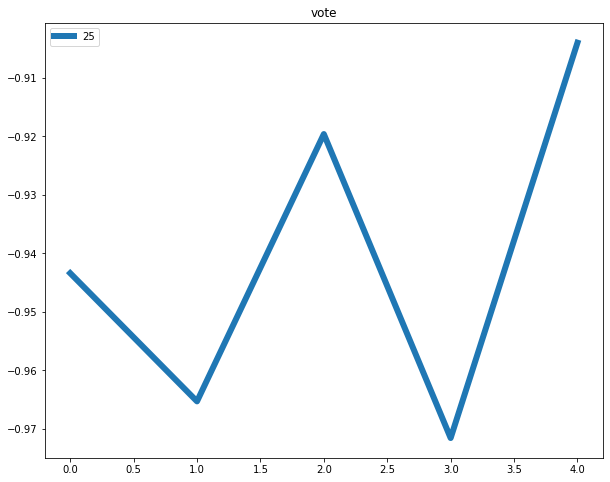

In [290]:
window = 10
bars = 5
n_neighbors = 25

for n, cv in means[window][bars].to_dict().items():
    if n != n_neighbors: continue
    pd.Series(cv, name=n).plot(lw=6, figsize=(10,8), title='vote')
    print(n)
    print(cv)
plt.legend()
plt.show()

## Learning rate

In [ ]:
# from sklearn.model_selection import learning_curve

# model = KNeighborsRegressor(n_neighbors=1, n_jobs=-1)
# train_sizes, train_scores, valid_scores = learning_curve(model, x_train, y_train,
#                                                          train_sizes=[0.2, 0.4, 0.6, 0.8, 1],
#                                                          cv=3, scoring='neg_mean_absolute_error',
#                                                          n_jobs=-1, verbose=2)
# valid = pd.DataFrame(valid_scores).sum(axis=1)
# train = pd.DataFrame(train_scores).sum(axis=1)
# learning_rate = pd.concat([valid, train], axis=1)
# learning_rate.columns = ['valid', 'train']
# learning_rate.plot()

## Out of sample test

In [12]:
all_files = [
             'EURUSD_1h_2003-2010.csv', 'EURUSD_1h_2010-2020.csv',
             'USDJPY_1h_2003-2010.csv', 'USDJPY_1h_2010-2020.csv',
             'NZDUSD_1h_2003-2020.csv',
             'AUDUSD_1h_2003-2020.csv',
             'USDCAD_1h_2003-2020.csv',
            ]
data = prep_fx_data(all_files)

EURUSD_1h_2003-2010.csv
EURUSD_1h_2010-2020.csv
USDJPY_1h_2003-2010.csv
USDJPY_1h_2010-2020.csv
NZDUSD_1h_2003-2020.csv
AUDUSD_1h_2003-2020.csv
USDCAD_1h_2003-2020.csv


In [ ]:
gpu_step_size= 50

global trade_fees_pct
global min_pred_target_size_pct
trade_fees_pct = 0.0001 #1/15 #0.0001
min_pred_target_size_pct = 0.0004 #(1/15)*4 #0.0006
resample = None #None #'1D'
norm_by_vol = False
close_only = False

ensemble = False # False # 'vote'
scale_only = True

## template ##
# ?w - ?c - ?n # ? romad # filter: ? romad, ? trades

##    ##
#1 hour data

# Daily resample

## Norm by vol ##
#1 hour data

# Daily resample

## Close only ##
#1 hour data

# Daily resample


best_risk = {}
pred_ensemble = []
all_i_data = {}
for neighbors in [25]:
    for window in [150]:
        n_candles = [100]

        (x_train, y_train, x_test, y_test, train_data_raw,
        test_data_raw, knn_data) = fit_data_for_knn(data, window=window,
                                                    n_candles=n_candles,
                                                    close_only=close_only,
                                                    norm_by_vol=norm_by_vol,
                                                    resample=resample,
                                                    train_split=0.7)

        if scale_only:
            x_train, x_test = scale_data(x_train, x_test, df=True)
        print('got data')

        all_indices = knn_cuda(x_train, x_test, n_neighbors=neighbors, gpu_step_size=gpu_step_size)
        y_train_numpy = y_train.to_numpy()

        for scorer, scorer_func in [('mean',np.mean)]:#, ('median',np.median)]:       
            pred = [scorer_func(y_train_numpy[d]) for d in all_indices]
            print('predictions done')

            romad, i_data = cuda_trading_scorer(pred, y_test, n_candles, return_df=True)
            all_i_data.setdefault(scorer, {})
            all_i_data[scorer][(window, neighbors)] = i_data

            for c in n_candles:
                target_col = f'target_bars_{c}'

                i_data[f'profit_{target_col}'].plot()
                plt.show()

                i_data['sortino_profit'] = i_data[f'profit_{target_col}'].map(
                                                    lambda x: 0 if x > 0 else x)

                sortino = (i_data[f'run_profit_{target_col}'].values[-1] 
                          / i_data['sortino_profit'].std())  
                best_risk[(window, neighbors)] = (romad, sortino)

                i_data[f'run_profit_{target_col}'].plot(title=f'window_{window}_n_candles_{c}'
                                                              f'_neighbors_{neighbors}_{scorer}')
                plt.show()

            if ensemble == 'vote':
                # used later to concatenate each set of predictions and form an ensemble
                pred_ensemble.append(pred)
  
gc.collect()
best_risk

In [240]:
if ensemble == 'vote':
    ensemble_results = {}
    for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]: #[0.5]
        score_mean, ensemble_data = cuda_trading_scorer_vote(pred_ensemble, y_test,
                     output_candles=n_candles, threshold=threshold, return_df=True)    
        ensemble_results[threshold] = (score_mean, ensemble_data)
    ensemble_romads = {k:v[0] for k,v in ensemble_results.items()}
    plot_heatmap_table(pd.DataFrame(ensemble_romads), title='ensemble', figsize=(5,5))

In [241]:
if ensemble == 'vote':
    threshold = 0.3
    ensemble_bars = 100
    neighbors = [5,10,25,100,200,500] #must be the same as test!
    windows = [10,30,50,100] #must be the same as test!
    title = (f'ensemble_threshold_{threshold}_n_candles_{ensemble_bars}\n'
             f'neighbors_{neighbors}\n'
             f'windows_{windows}')
    ensemble_results[threshold][1][f'run_profit_target_bars_{ensemble_bars}'].plot(title=title)
    num_trades = (ensemble_results[threshold][1]['pred_dir'] != 0).sum()
    print('num_trades:', num_trades)

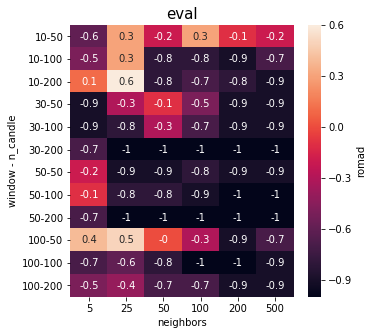

In [249]:
eval_data = {}
for (window, neighbor), values in best_risk.items():
    for candle, romad in values[0].items():
        eval_data.setdefault((window, candle), {}) 
        eval_data[(window, candle)][neighbor] = romad
eval_df = pd.DataFrame(eval_data).T
plot_heatmap_table(eval_df, title='eval', figsize=(5,5))

In [253]:
eval_df

5         25        50        100       200       500
10  50  -0.605544  0.275135 -0.191734  0.260907 -0.066352 -0.226705
    100 -0.491933  0.319043 -0.838848 -0.810486 -0.850653 -0.707099
    200  0.091918  0.576823 -0.760207 -0.674364 -0.839530 -0.884751
30  50  -0.909513 -0.303483 -0.102627 -0.512624 -0.870438 -0.872257
    100 -0.898820 -0.788383 -0.335028 -0.687501 -0.908747 -0.939666
    200 -0.748321 -0.971526 -0.977373 -0.998620 -0.999226 -0.999727
50  50  -0.240103 -0.863746 -0.927832 -0.757775 -0.920711 -0.924266
    100 -0.083522 -0.824589 -0.831232 -0.893655 -0.963040 -0.958501
    200 -0.665386 -0.956324 -0.974551 -0.978996 -1.001945 -1.001945
100 50   0.371544  0.481281 -0.009118 -0.327339 -0.870129 -0.679855
    100 -0.746709 -0.557231 -0.810276 -0.984302 -1.001052 -0.883762
    200 -0.453082 -0.375289 -0.687124 -0.694366 -0.941275 -0.857663

## Evaluate different prediction thresholds

num_trades: 5453
romad: -0.94


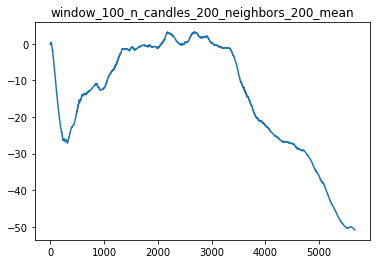

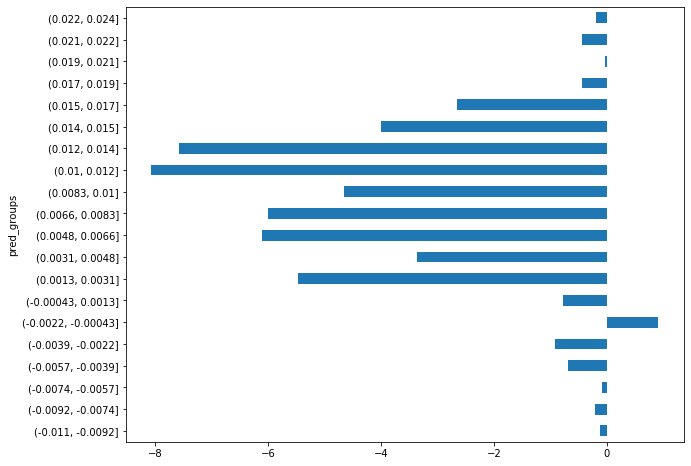

In [276]:
window = 100
n_candle = 200
neighbor = 200

scorer = 'mean'
target_col = f'target_bars_{n_candle}'

all_i_data_filter = all_i_data[scorer][(window, neighbor)].copy()
print('num_trades:', (all_i_data_filter['pred_dir'] != 0).sum())
print('romad:', eval_df.loc[(window, n_candle)][neighbor].round(2))
all_i_data_filter[f'run_profit_{target_col}'].plot(title=f'window_{window}_n_candles_{n_candle}'
                                         f'_neighbors_{neighbor}_{scorer}')
plt.show()


grouping_data = all_i_data_filter.copy()
all_i_data_filter['pred_groups'] = pd.cut(grouping_data['pred'], 20, precision=0)
pred_group = all_i_data_filter.groupby('pred_groups').sum()
pred_group[f'profit_{target_col}'].plot.barh(figsize=(10,8))

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.67it/s]


best: {(3.052816293199386e-07, 0.0032067127167680486): -0.31906600564036475}
num of trades: 1087


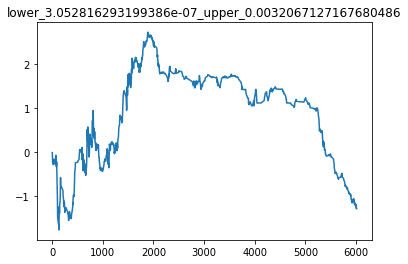

Romad: -0.31906600564036475


In [269]:
min_num_trades = 1000
num_intervals = 30

smallest_pred = all_i_data_filter['pred'].abs().min()
largest_pred = all_i_data_filter['pred'].abs().max()
interval_size = (largest_pred - smallest_pred) / num_intervals

romad_scores = {}
for lower in tqdm(np.arange(smallest_pred, largest_pred, interval_size)):
    for upper in np.arange(smallest_pred, largest_pred, interval_size):
        subset = all_i_data_filter[((all_i_data_filter['pred'] > -upper) 
                                     & (all_i_data_filter['pred'] < upper)) 
                                     & ((all_i_data_filter['pred'] < -lower) 
                                        | (all_i_data_filter['pred'] > lower))]
        if (subset['pred_dir'] != 0).sum() < min_num_trades:
            continue
        run_profit = subset[f'profit_{target_col}'].cumsum()
        romad = calc_romad(run_profit)
        romad_scores[(lower, upper)] = romad
best = pd.Series(romad_scores).sort_values(ascending=False).head(1).to_dict()
print('best:',best)
best_lower = list(best.keys())[0][0]
best_upper = list(best.keys())[0][1]

best_subset = all_i_data_filter[((all_i_data_filter['pred'] > -best_upper) 
                                 & (all_i_data_filter['pred'] < best_upper)) 
                                 & ((all_i_data_filter['pred'] < -best_lower) 
                                    | (all_i_data_filter['pred'] > best_lower))]

print('num of trades:',(best_subset['pred_dir'] != 0).sum())
best_subset[f'profit_{target_col}'].cumsum().plot(title=f'lower_{best_lower}_upper_{best_upper}')
plt.show()
run_profit = best_subset[f'profit_{target_col}'].cumsum()
romad = calc_romad(run_profit)
print('Romad:',romad)

num of trades: 2075


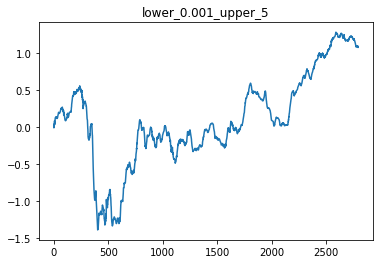

Romad: 0.5547504713854247


In [208]:
manual_upper = 5
manual_lower = 0.001
manual_subset = all_i_data_filter[((all_i_data_filter['pred'] > -manual_upper) 
                                 & (all_i_data_filter['pred'] < manual_upper)) 
                                 & ((all_i_data_filter['pred'] < -manual_lower) 
                                    | (all_i_data_filter['pred'] > manual_lower))]

print('num of trades:',manual_subset.shape[0])
manual_subset[f'profit_{target_col}'].cumsum().plot(title=f'lower_{manual_lower}_upper_{manual_upper}')
plt.show()
run_profit = manual_subset[f'profit_{target_col}'].cumsum()
romad = calc_romad(run_profit)
print('Romad:',romad)

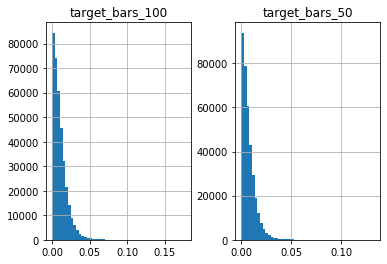

In [33]:
ax = y_train.abs().hist(bins=50)

![title](training_learning_rate_vs_n_neighbors.png)